In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!unzip -u '/content/drive/MyDrive/poets/russian_literature.zip' -d '/content/drive/MyDrive/poets/'

In [ ]:
!dir '/content/drive/MyDrive/poets/'
!dir '/content/drive/MyDrive/poets/poems/'
!dir '/content/drive/MyDrive/poets/prose/'
!dir '/content/drive/MyDrive/poets/publicism/'

poems  prose  publicism
Blok  Lermontov  Nekrasov  Pushkin
Blok  Bryusov  Chekhov	Dostoevsky  Gogol  Gorky  Herzen  Lermontov  Pushkin  Tolstoy  Turgenev
Tolstoy


In [ ]:
# Загрузка необходимых библиотек
import glob # Вспомогательный модуль для работы с файловой системой
import numpy as np
from keras import utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # Для работы с матрицей ошибок


# Выбираем их явно, чтобы список был перед глазами, и отложилось в голове, что имена писателей (точнее их порядковый номер) - это метки
CLASS_LIST=['Blok', 'Lermontov', 'Nekrasov', 'Pushkin', 'Bryusov', 'Chekhov', 'Dostoevsky', 'Gogol', 'Gorky', 'Herzen', 'Tolstoy', 'Turgenev']

all_texts = {} # Собираем в словарь весь датасет

for author in CLASS_LIST:
  all_texts[author] = '' # Инициализируем пустой строкой новый ключ словаря
  for path in glob.glob('/content/drive/MyDrive/poets/poems/{}/*.txt'.format(author)) +  glob.glob('/content/drive/MyDrive/poets/prose/{}/*.txt'.format(author)) +  glob.glob('/content/drive/MyDrive/poets/publicism/{}/*.txt'.format(author)): # Поиск файлов по шаблону
    with open(f'{path}', 'r', errors='ignore') as f: # игнорируем ошибки (например символы из другой кодировки)
                # Загрузка содержимого файла в строку
                text = f.read()

    all_texts[author]  += ' ' + text.replace('\n', ' ') # Заменяем символ перехода на новую строку пробелом


In [ ]:
# Создаем новый список с писателями у которых наибольший объем текста
total = sorted([len(i) for i in all_texts.values()], reverse = True)[:5]
CLASS_LIST_NEW = []
for author in CLASS_LIST:
  for j in total:
    if len(all_texts[author]) == j:
      CLASS_LIST_NEW.append(author)
print(f'Писатели с большими объемами текста: {CLASS_LIST_NEW}')

# Авторы которых необходимо удалить
del_author = [x for x in CLASS_LIST if x not in CLASS_LIST_NEW]

# Удаление авторов из словаря all_texts
for author in del_author:
    all_texts.pop(author, None)

print(all_texts.keys())

Писатели с большими объемами текста: ['Bryusov', 'Dostoevsky', 'Gorky', 'Tolstoy', 'Turgenev']
dict_keys(['Bryusov', 'Dostoevsky', 'Gorky', 'Tolstoy', 'Turgenev'])


Общая выборка по писателям:
Bryusov - 2830897 символов, доля в общей базе: 9.21%
Dostoevsky - 11221679 символов, доля в общей базе: 36.51%
Gorky - 4324025 символов, доля в общей базе: 14.07%
Tolstoy - 10011108 символов, доля в общей базе: 32.57%
Turgenev - 2345243 символов, доля в общей базе: 7.63%


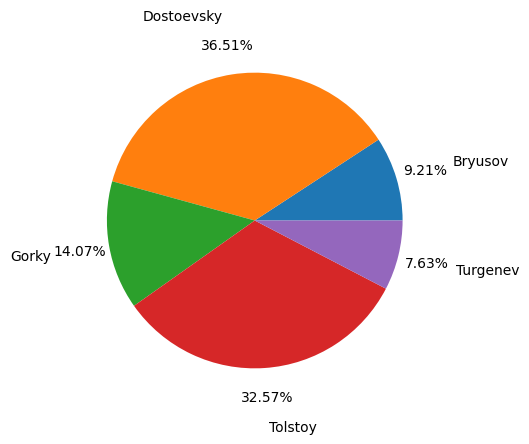

In [ ]:
total_sum = sum([len(all_texts[author]) for author in CLASS_LIST_NEW])

print('Общая выборка по писателям:')
for author in CLASS_LIST_NEW:
    percentage = (len(all_texts[author]) / total_sum) * 100
    print(f'{author} - {len(all_texts[author])} символов, доля в общей базе: {percentage:.2f}%')


import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots()
ax.pie([len(i) for i in all_texts.values()], # формируем список значений как длина символов текста каждого автора
       labels=CLASS_LIST_NEW,                    # список меток
       pctdistance=1.2,                      # дистанция размещения % (1 - граница окружности)
       labeldistance=1.4,                    # размещение меток (1 - граница окружности)
       autopct='%1.2f%%'                     # формат для % (2 знака после запятой)
      )
plt.show()

In [ ]:
!wget https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar
!pip install navec
from navec import Navec

navec = Navec.load('navec_hudlit_v1_12B_500K_300d_100q.tar')

--2024-04-11 13:22:57--  https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53012480 (51M) [application/x-tar]
Saving to: ‘navec_hudlit_v1_12B_500K_300d_100q.tar.1’

navec_hudlit_v1_12B 100%[===================>]  50.56M  16.7MB/s    in 3.3s    

2024-04-11 13:23:01 (15.3 MB/s) - ‘navec_hudlit_v1_12B_500K_300d_100q.tar.1’ saved [53012480/53012480]



In [ ]:
!pip install razdel

In [ ]:
from razdel import tokenize, sentenize

embedding_dim = 300
max_words = 238777

# Использование токенизатора Razdel
seq_train = []
words = []
word_index = {}  # Создаем словарь для хранения индексов слов

for i in CLASS_LIST_NEW:
    tokens = list(tokenize(all_texts[i]))
    seq = []
    for token in tokens:
        word = token.text.lower()  # Приводим текст токена к нижнему регистру
        if word not in word_index:
            word_index[word] = len(word_index) + 1  # Используем индексы, начинающиеся с 1
        seq.append(word_index[word])
        words.append(word)
    seq_train.append(seq)

print(f'Количество слов: {len(word_index)}')

# Преобразуем список уникальных слов в список, чтобы сохранить порядок
words = word_index.keys()
print(f'Количество уникальных слов: {len(words)}')

Количество слов: 221307
Количество уникальных слов: 221307


In [ ]:
seq_train_balance = [seq_train[cls] for cls in range(len(CLASS_LIST_NEW))]

# используем генератор цикла для получения длины текстов по каждому автору
total = sum(len(i) for i in seq_train_balance)
print(f'Датасет состоит из {total} слов')

Датасет состоит из 6127112 слов


Общая выборка по писателям (по словам):
Bryusov - 531982 слов, доля в общей базе: 8.68%
Dostoevsky - 2256313 слов, доля в общей базе: 36.83%
Gorky - 888673 слов, доля в общей базе: 14.50%
Tolstoy - 1975249 слов, доля в общей базе: 32.24%
Turgenev - 474895 слов, доля в общей базе: 7.75%
Среднее значение слов:  1225422.0
Медианное значение слов:  888673.0


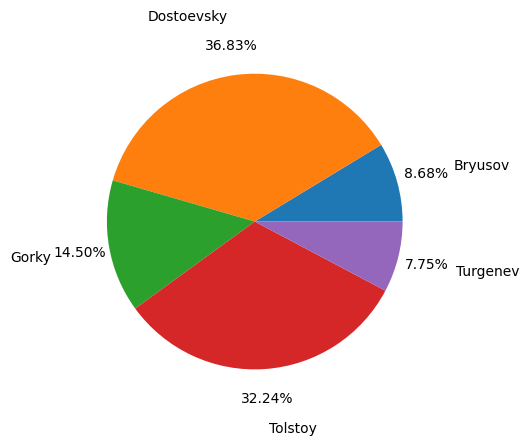

In [ ]:
import numpy as np

print('Общая выборка по писателям (по словам):')
mean_list = np.array([])
for author in CLASS_LIST_NEW:
    cls = CLASS_LIST_NEW.index(author)
    print(f'{author} - {len(seq_train_balance[cls])} слов, доля в общей базе: {len(seq_train_balance[cls])/total*100 :.2f}%')
    mean_list = np.append(mean_list, len(seq_train_balance[cls]))

print('Среднее значение слов: ', np.round(mean_list.mean()))
print('Медианное значение слов: ', np.median(mean_list))

import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots()
ax.pie([len(i) for i in seq_train_balance], # формируем список значений как длина символов текста каждого автора
       labels=CLASS_LIST_NEW,                    # список меток
       pctdistance=1.2,                      # дистанция размещения % (1 - граница окружности)
       labeldistance=1.4,                    # размещение меток (1 - граница окружности)
       autopct='%1.2f%%'                     # формат для % (2 знака после запятой)
      )
plt.show()

In [ ]:
seq_train_balance = [seq_train[cls][:200000] for cls in range(len(CLASS_LIST_NEW))]

# используем генератор цикла для получения длины текстов по каждому автору
total = sum(len(i) for i in seq_train_balance)
print(f'Датасет состоит из {total} слов')

Датасет состоит из 1000000 слов


Общая выборка по писателям (по словам):
Bryusov - 200000 слов, доля в общей базе: 20.00%
Dostoevsky - 200000 слов, доля в общей базе: 20.00%
Gorky - 200000 слов, доля в общей базе: 20.00%
Tolstoy - 200000 слов, доля в общей базе: 20.00%
Turgenev - 200000 слов, доля в общей базе: 20.00%
Среднее значение слов:  200000.0
Медианное значение слов:  200000.0


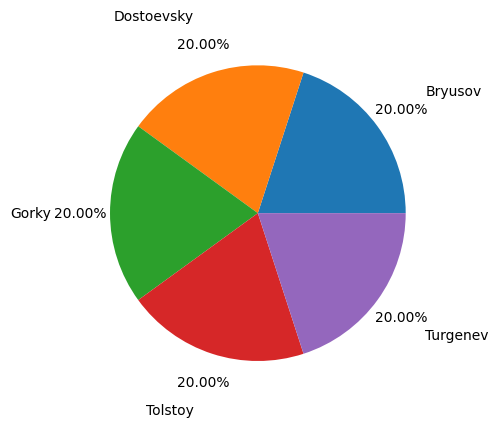

In [ ]:
import numpy as np

print('Общая выборка по писателям (по словам):')
mean_list = np.array([])
for author in CLASS_LIST_NEW:
    cls = CLASS_LIST_NEW.index(author)
    print(f'{author} - {len(seq_train_balance[cls])} слов, доля в общей базе: {len(seq_train_balance[cls])/total*100 :.2f}%')
    mean_list = np.append(mean_list, len(seq_train_balance[cls]))

print('Среднее значение слов: ', np.round(mean_list.mean()))
print('Медианное значение слов: ', np.median(mean_list))

import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots()
ax.pie([len(i) for i in seq_train_balance], # формируем список значений как длина символов текста каждого автора
       labels=CLASS_LIST_NEW,                    # список меток
       pctdistance=1.2,                      # дистанция размещения % (1 - граница окружности)
       labeldistance=1.4,                    # размещение меток (1 - граница окружности)
       autopct='%1.2f%%'                     # формат для % (2 знака после запятой)
      )
plt.show()

In [ ]:
WIN_SIZE = 1000   # Ширина окна в токенах
WIN_STEP = 100    # Шаг окна в токенах

# Функция разбиения последовательности на отрезки скользящим окном
# Последовательность разбивается на части до последнего полного окна
# Параметры:
# sequence - последовательность токенов
# win_size - размер окна
# step - шаг окна
def seq_split(sequence, win_size, step):
    # Делим строку на отрезки с помощью генератора цикла
    return [sequence[i:i + win_size] for i in range(0, len(sequence) - win_size + 1, step)]

def seq_vectorize(
    seq_list,   # Последовательность
    test_split, # Доля на тестовую сборку
    class_list, # Список классов
    win_size,   # Ширина скользящего окна
    step        # Шаг скользящего окна
):

    # Списки для результирующих данных
    x_train, y_train, x_test, y_test =  [], [], [], []

    # Пробежимся по всем классам:
    for class_item in class_list:
        # Получим индекс класса
        cls = class_list.index(class_item)

        # Пороговое значение индекса для разбивки на тестовую и обучающую выборки
        gate_split = int(len(seq_list[cls]) * (1-test_split))

        # Разбиваем последовательность токенов класса на отрезки
        vectors_train = seq_split(seq_list[cls][:gate_split], win_size, step) # последовательность до порога попадет в обучающую выборку
        vectors_test = seq_split(seq_list[cls][gate_split:], win_size, step)  # последовательность после порога попадет в тестовую выборку

        # Добавляем отрезки в выборку
        x_train += vectors_train
        x_test += vectors_test

        # Для всех отрезков класса добавляем метки класса в виде one-hot-encoding
        # Каждую метку берем len(vectors) раз, так она одинакова для всех выборок одного класса
        y_train += [keras.utils.to_categorical(cls, len(class_list))] * len(vectors_train)
        y_test += [keras.utils.to_categorical(cls, len(class_list))] * len(vectors_test)

    # Возвращаем результатов как numpy-массивов
    return np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)

In [ ]:
import keras
x_train, y_train, x_test, y_test = seq_vectorize(seq_train_balance, 0.1, CLASS_LIST_NEW, WIN_SIZE, WIN_STEP)

print(x_train.dtype)
print(y_train.dtype)

int64
float32


In [ ]:
print(f'Форма входных данных для обучающей выборки: {x_train.shape}')
print(f'Форма выходных данных (меток) для обучающей выборки: {y_train.shape}')
print(f'Форма входных данных для тестовой выборки: {x_test.shape}')
print(f'Форма выходных данных (меток) для тестовой выборки: {y_test.shape}')

Форма входных данных для обучающей выборки: (8955, 1000)
Форма выходных данных (меток) для обучающей выборки: (8955, 5)
Форма входных данных для тестовой выборки: (955, 1000)
Форма выходных данных (меток) для тестовой выборки: (955, 5)


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # Для работы с матрицей ошибок

# Вывод графиков точности и ошибки
def show_plot(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))
    fig.suptitle('График процесса обучения модели')
    ax1.plot(history.history['accuracy'],
               label='График точности на обучающей выборке')
    ax1.plot(history.history['val_accuracy'],
               label='График точности на проверочной выборке')
    ax1.xaxis.get_major_locator().set_params(integer=True) # На оси х показываем целые числа
    ax1.set_xlabel('Эпоха обучения')
    ax1.set_ylabel('График точности')
    ax1.legend()

    ax2.plot(history.history['loss'],
               label='Ошибка на обучающей выборке')
    ax2.plot(history.history['val_loss'],
               label='Ошибка на проверочной выборке')
    ax2.xaxis.get_major_locator().set_params(integer=True) # На оси х показываем целые числа
    ax2.set_xlabel('Эпоха обучения')
    ax2.set_ylabel('Ошибка')
    ax2.legend()
    plt.show()

# Функция вывода предсказанных значений
def show_confusion_matrix(y_true, y_pred, class_labels):
    # Матрица ошибок
    cm = confusion_matrix(np.argmax(y_true, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')
    # Округление значений матрицы ошибок
    cm = np.around(cm, 3)

    # Отрисовка матрицы ошибок
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_title(f'Матрица ошибок', fontsize=18)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(ax=ax)
    plt.gca().images[-1].colorbar.remove()  # Убираем ненужную цветовую шкалу
    plt.xlabel('Предсказанные классы', fontsize=16)
    plt.ylabel('Верные классы', fontsize=16)
    fig.autofmt_xdate(rotation=45)          # Наклон меток горизонтальной оси
    plt.show()


    # Средняя точность распознавания определяется как среднее диагональных элементов матрицы ошибок
    print('\nСредняя точность распознавания: {:3.0f}%'.format(100. * cm.diagonal().mean()))


In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, SpatialDropout1D, BatchNormalization, Dropout

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=WIN_SIZE))
model.add(BatchNormalization())
model.add(Dense(40, activation="relu"))
model.add(Dropout(0.6))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(len(CLASS_LIST_NEW), activation='softmax'))


In [ ]:
import numpy as np

# Создание индекса слов
word_index = {}
embeddings_index = navec
index = 1  # Начинаем с 1, так как 0 будет зарезервирован для паддинга
for author_tokenized_text in seq_train:
    for token_text in author_tokenized_text:
        if isinstance(token_text, str):
            token_text = token_text.lower()
            if token_text not in word_index:
                word_index[token_text] = index
                index += 1

# Создание матрицы векторных представлений
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector


In [ ]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=10, batch_size=64, validation_split=0.1)

In [ ]:
from keras.layers import Embedding, Flatten, Dense, SpatialDropout1D, BatchNormalization, Dropout, SimpleRNN
from keras.layers import GRU, LSTM, Bidirectional, Conv1D, MaxPooling1D, GlobalMaxPooling1D

model_MIX = Sequential()
model_MIX.add(Embedding(max_words, embedding_dim, input_length=WIN_SIZE))
model_MIX.add(SpatialDropout1D(0.3))
model_MIX.add(BatchNormalization())

# Два двунаправленных рекуррентных слоя LSTM
model_MIX.add(Bidirectional(LSTM(8, return_sequences=True)))
model_MIX.add(Bidirectional(LSTM(8, return_sequences=True)))
model_MIX.add(Dropout(0.3))
model_MIX.add(BatchNormalization())

# Два рекуррентных слоя GRU
model_MIX.add(GRU(16, return_sequences=True, reset_after=True))
model_MIX.add(GRU(16, reset_after=True))
model_MIX.add(Dropout(0.3))
model_MIX.add(BatchNormalization())

# Дополнительный полносвязный слой
model_MIX.add(Dense(100, activation='relu'))
model_MIX.add(Dropout(0.3))
model_MIX.add(BatchNormalization())
model_MIX.add(Dense(len(CLASS_LIST_NEW), activation='softmax'))

In [ ]:
model_MIX.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_mix = model_MIX.fit(x_train, y_train, epochs=10, batch_size=64, validation_data=(x_test, y_test))

Epoch 1/10
140/140 [==============================] - 868s 6s/step - loss: 1.6836 - accuracy: 0.3082 - val_loss: 1.5923 - val_accuracy: 0.2115
Epoch 2/10
140/140 [==============================] - 845s 6s/step - loss: 1.0924 - accuracy: 0.5391 - val_loss: 0.9897 - val_accuracy: 0.5340
Epoch 3/10
140/140 [==============================] - 840s 6s/step - loss: 0.6523 - accuracy: 0.7285 - val_loss: 0.8534 - val_accuracy: 0.6492
Epoch 4/10
140/140 [==============================] - 839s 6s/step - loss: 0.3345 - accuracy: 0.8860 - val_loss: 0.9064 - val_accuracy: 0.7225
Epoch 5/10
140/140 [==============================] - 842s 6s/step - loss: 0.1426 - accuracy: 0.9636 - val_loss: 0.9707 - val_accuracy: 0.7445
Epoch 6/10
140/140 [==============================] - 832s 6s/step - loss: 0.0767 - accuracy: 0.9818 - val_loss: 1.1650 - val_accuracy: 0.7277
Epoch 7/10
140/140 [==============================] - 869s 6s/step - loss: 0.0454 - accuracy: 0.9906 - val_loss: 1.1043 - val_accuracy: 0.7497

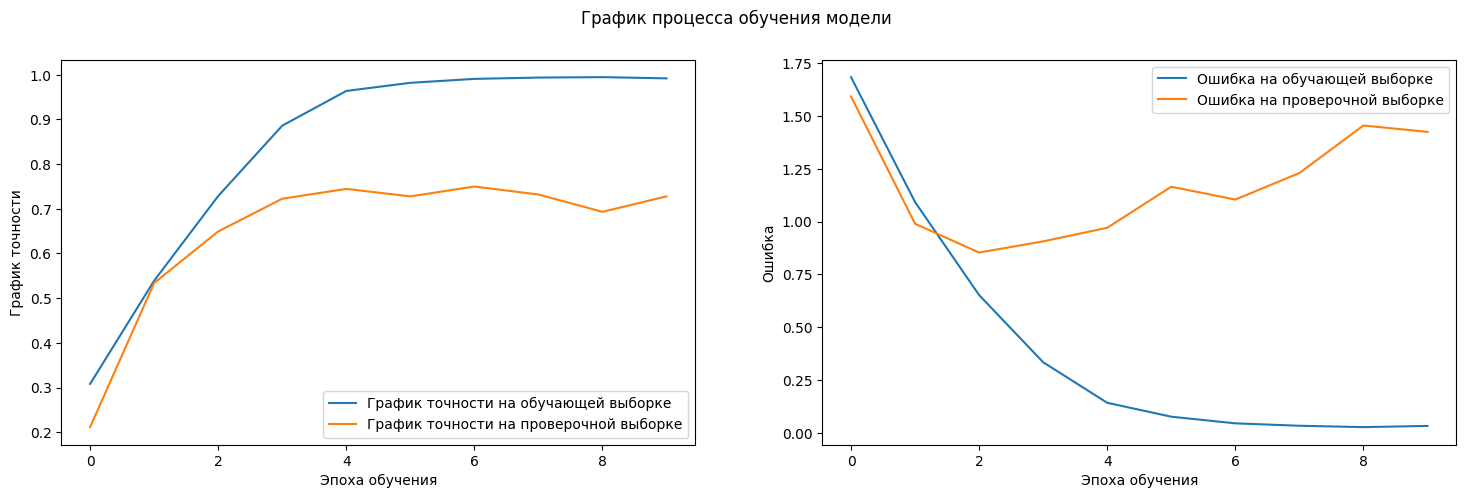

In [ ]:
show_plot(history_mix)